In [1]:
import numpy as np
import cvxpy as cp
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Generate data for Huber regression.
np.random.seed(1)
n = 300
SAMPLES = int(1.5*n)
beta_true = 5*np.random.normal(size=(n,1))
X = np.random.randn(n, SAMPLES)
Y = np.zeros((SAMPLES,1))
v = np.random.normal(size=(SAMPLES,1))

In [3]:
print(X.shape)
print(Y.shape)
print(v.shape)
print(beta_true.shape)

(300, 450)
(450, 1)
(450, 1)
(300, 1)


### CVXPY

In [4]:
TESTS = 50
huber_data = np.zeros(TESTS)
p_vals = np.linspace(0,0.15, num=TESTS)

In [5]:
print(huber_data.shape)
print(huber_data)
print(p_vals)

(50,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.         0.00306122 0.00612245 0.00918367 0.0122449  0.01530612
 0.01836735 0.02142857 0.0244898  0.02755102 0.03061224 0.03367347
 0.03673469 0.03979592 0.04285714 0.04591837 0.04897959 0.05204082
 0.05510204 0.05816327 0.06122449 0.06428571 0.06734694 0.07040816
 0.07346939 0.07653061 0.07959184 0.08265306 0.08571429 0.08877551
 0.09183673 0.09489796 0.09795918 0.10102041 0.10408163 0.10714286
 0.11020408 0.11326531 0.11632653 0.11938776 0.12244898 0.1255102
 0.12857143 0.13163265 0.13469388 0.1377551  0.14081633 0.14387755
 0.14693878 0.15      ]


In [6]:
%%time
Y_s = []
for idx, p in enumerate(p_vals):
    
    factor = 2*np.random.binomial(1, 1-p, size=(SAMPLES,1)) - 1
    Y = factor*X.T.dot(beta_true) + v
    Y_s.append(Y)
    beta = cp.Variable((n,1))
    fit = cp.norm(beta - beta_true)/cp.norm(beta_true)
    cost = cp.sum(cp.huber(X.T*beta - Y, 1))
    cp.Problem(cp.Minimize(cost)).solve()
    huber_data[idx] = fit.value


CPU times: user 49.3 s, sys: 6.17 s, total: 55.5 s
Wall time: 15.1 s


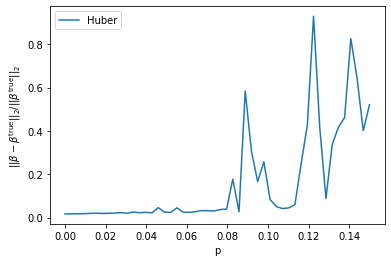

In [7]:
plt.plot(p_vals, huber_data, label='Huber')
plt.ylabel(r'$\||\beta - \beta^{\mathrm{true}}\||_2/\||\beta^{\mathrm{true}}\||_2$')
plt.xlabel('p')
plt.legend(loc='upper left')
plt.show()

### Torch

In [8]:
inputs = torch.from_numpy(X.T)
print(inputs)

tensor([[ 2.0658e+00,  1.5365e+00, -5.3903e-01,  ...,  1.7127e-01,
         -4.0097e-01, -4.2941e-01],
        [-1.4712e+00, -3.7501e-04,  6.4410e-01,  ...,  4.5984e-01,
         -1.8288e-02,  1.5262e+00],
        [-8.3017e-01,  1.2935e+00,  1.8363e-01,  ...,  1.9132e-01,
         -2.3015e+00,  3.7185e-01],
        ...,
        [ 4.0008e-03, -1.4490e+00,  4.3913e-01,  ...,  2.9422e-01,
         -3.5162e-01,  4.0545e-01],
        [ 3.2127e-01,  7.7949e-01, -1.1030e+00,  ...,  1.2667e-01,
          8.5643e-01,  2.5469e-01],
        [-7.2521e-01, -1.0863e+00,  7.5949e-01,  ...,  2.0586e-01,
          2.0738e+00, -2.9558e-01]], dtype=torch.float64)


In [9]:
def huber_loss(y, y_pred, sigma=0.1):
    r = (y - y_pred).abs()
    loss = (r[r <= sigma]).pow(2).mean()
    loss += 2*(r[r > sigma]).mean() * sigma - sigma**2
    return loss

In [10]:
%%time
huber_data_t = []
for y in Y_s:
    targets = torch.from_numpy(y)
    model = torch.nn.Linear(in_features=300, out_features=1)
    opt = torch.optim.SGD(model.parameters(), lr = 0.2)
    criterion = torch.nn.SmoothL1Loss()

    for epoch in range(100):

        preds = model(inputs.float())
        loss = criterion(targets.float(), preds)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    huber_data_t.append(torch.norm(model.weight-torch.from_numpy(beta_true))/torch.norm(torch.from_numpy(beta_true)))

CPU times: user 40.4 s, sys: 521 ms, total: 40.9 s
Wall time: 2.82 s


### Torch работает существенно быстрее, но качество заметно хуже
#### возможно я допустила ошибку

In [11]:
huber_data_t

[tensor(17.8541, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8431, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8571, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8364, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8494, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8267, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8359, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8165, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8121, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8292, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8274, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8243, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8323, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8129, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.8291, dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(17.7860, dtype=torch.float64, grad_fn=<DivBackw